In [ ]:
import pandas as pd
import polars as pl
import numpy as np
import typing as t
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from tqdm import tqdm
from dataclasses import dataclass
import pickle
import os
import scipy.sparse

In [2]:
processed_data_folder = "processed_data/"

books_preprocessed = pl.read_parquet(processed_data_folder + "books_preprocessed.pq")
user_features = pl.read_parquet(processed_data_folder + "user_features.pq")
train_data = pl.read_parquet(processed_data_folder + "train_data.pq")
val_data = pl.read_parquet(processed_data_folder + "val_data.pq")
val_ground_truth = pl.read_parquet(processed_data_folder + "val_ground_truth.pq")

interaction_matrix = scipy.sparse.load_npz(processed_data_folder + "interaction_matrix.npz")

with open(processed_data_folder + "user_to_idx.pkl", "rb") as f:
    user_to_idx = pickle.load(f)
    
with open(processed_data_folder + "item_to_idx.pkl", "rb") as f:
    item_to_idx = pickle.load(f)

with open(processed_data_folder + "cold_items.pkl", "rb") as f:
    cold_items = pickle.load(f)
    
with open(processed_data_folder + "warm_items.pkl", "rb") as f:
    warm_items = pickle.load(f)

data_folder = "data/"
test_exploded = pl.read_parquet(data_folder + "test.pq")
test = test_exploded.group_by("user_id", maintain_order=True).agg(pl.col("item_id"))

In [ ]:
train_data = pl.read_parquet("processed_data/train_data.pq")
missing_users = set(val_ground_truth["user_id"].to_list()) - set(train_data["user_id"].unique().to_list())
print("Валидационные пользователи:", len(val_ground_truth))
print("Отсутствуют в train_data:", len(missing_users))
assert len(missing_users) == 0

Валидационные пользователи: 161758
Отсутствуют в train_data: 0


In [4]:
val_items = set(val_data["item_id"].unique().to_list())
train_items = set(train_data["item_id"].unique().to_list())
val_cold_items = val_items - train_items

print(f"Количество холодных айтемов в валидации: {len(val_cold_items)}")

Количество холодных айтемов в валидации: 2092


In [5]:
idx_to_item = {idx: item_id for item_id, idx in item_to_idx.items()}
idx_to_user = {idx: user_id for user_id, idx in user_to_idx.items()}

print(f"Размер обучающей выборки: {train_data.shape[0]} взаимодействий")
print(f"Размер валидационной выборки: {val_data.shape[0]} взаимодействий")
print(f"Количество пользователей в валидационной выборке: {len(val_ground_truth)}")
print(f"Количество холодных айтемов: {len(cold_items)}")
print(f"Количество теплых айтемов: {len(warm_items)}")


Размер обучающей выборки: 8858735 взаимодействий
Размер валидационной выборки: 2385165 взаимодействий
Количество пользователей в валидационной выборке: 161758
Количество холодных айтемов: 2092
Количество теплых айтемов: 29137


In [ ]:
n_books = books_preprocessed.shape[0]

# Набор валидационных метрик и обоснование их выбора

В задаче рекомендаций с холодными айтемами важно:
1. хорошо ранжировать релевантные книги (overall‑качество для тёплых)
2. уметь рекомендовать холодные (новые) книги
3. избегать одних и тех же рекомендаций

### Как устроена валидация:
- Валидируем только «тёплых» пользователей — как в тестовой выборке
- Разделение по времени: доля валидации = 0.21, доля cold‑взаимодействий = 0.05–0.06 — близко к тесту
- Для каждого пользователя `ground_truth` — список взаимодействий пользователя из валидационной выборки (ground truth), отсортированный по релевантности
- Рекомендации строятся из каталога `books`; позиции, которые пользователь уже видел в train, исключаются
- Фокус на `k=10` 

### Метрики качества
- NDCG@10: отражает качество ранжирования, учитывает позиции кликов/релевантов
- Recall@10: доля релевантных из `ground_truth`, попавших в топ‑10 (множество, без учёта порядка)
- Coverage: доля уникальных рекомендованных книг от всего каталога, прокси‑метрика разнообразия — не хотим рекомендовать всем одно и то же
- cold_recall@10: Recall@10, но считаем только по холодным релевантам, отражает способность рекомендовать новые книги
- cold_coverage — доля уникальных холодных книг, которые появились хотя бы в одном списке рекомендаций. Оценивает широту охвата холодных книг

### Почему именно этот набор:
- NDCG@10 + Recall@10: классическая пара для топ‑N рекомендации (ранг + полнота)
- Coverage: бизнес‑релевантная метрика разнообразия/охвата каталога
- Cold метрики показывают, умеет ли модель рекомендовать именно те новые книги, которые пользователю действительно интересны и насколько она широко охватывает новые книги

In [7]:
# ACHTUNG! DO NOT TOUCH

@dataclass
class AtKMetric(ABC):
    k: int

    @property
    @abstractmethod
    def name(self) -> str:
        raise NotImplementedError

    @property
    def full_name(self) -> str:
        return f"{self.name}@{self.k}"

    @abstractmethod
    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth") -> pl.Expr:
        raise NotImplementedError


class NDCG(AtKMetric):
    @property
    def name(self) -> str:
        return "ndcg"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth") -> pl.Expr:
        def _dcg(scores: np.ndarray) -> float:
            # Handle empty arrays
            if len(scores) == 0:
                return 0.0
            # Use vectorized operations for better performance
            positions = np.arange(1, len(scores) + 1, dtype=np.float64)
            return np.sum((np.power(2, scores) - 1) / np.log2(positions + 1))

        def ndcg(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            # Handle empty predictions or ground truth
            if not predicted or not gt_items:
                return 0.0
                
            # Take only top-k predictions
            predicted = predicted[:self.k]
            
            # Create relevance scores (1 for relevant items, 0 otherwise)
            relevance = np.array([1 if x in gt_items else 0 for x in predicted], dtype=np.float64)
            
            rank_dcg = _dcg(relevance)
            if rank_dcg == 0.0:
                return 0.0
                
            # Ideal DCG: sort ground truth by relevance (all 1s) and take top-k
            ideal_relevance = np.ones(min(len(gt_items), self.k), dtype=np.float64)
            ideal_dcg = _dcg(ideal_relevance)
            
            if ideal_dcg == 0.0:
                return 0.0
                
            return rank_dcg / ideal_dcg

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: ndcg(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)


class Recall(AtKMetric):
    @property
    def name(self) -> str:
        return "recall"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth") -> pl.Expr:
        def recall(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            # Handle empty ground truth
            if not gt_items:
                return 0.0
                
            # Take only top-k predictions
            predicted = predicted[:self.k]
            
            # Calculate intersection
            intersection = len(set(gt_items).intersection(set(predicted)))
            return intersection / len(gt_items)

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: recall(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)


def coverage(df: pl.DataFrame, n_items_in_catalog: int, preds_col: str = "preds") -> float:
    if n_items_in_catalog <= 0:
        return 0.0
        
    unique_recommended = df.select(
        pl.col(preds_col).explode().n_unique()
    ).item()
    return unique_recommended / n_items_in_catalog


def evaluate_recommender(
    df: pl.DataFrame,
    model_preds_col: str,
    ground_truth_col: str = "item_id",
    n_items_in_catalog: int = n_books,
    k: int = 10,
) -> dict:
    metrics = [
        NDCG(k=k),
        Recall(k=k),
    ]
    result = {}
    
    # Create a copy to avoid modifying the original dataframe
    result_df = df.clone()
    
    for metric in metrics:
        result_df = result_df.with_columns(
            metric(preds_col=model_preds_col, ground_truth_col=ground_truth_col)
        )
        result[metric.full_name] = round(result_df.select(pl.col(metric.full_name).mean()).item(), 3)

    if n_items_in_catalog is not None:
        result["coverage"] = round(coverage(result_df, n_items_in_catalog, preds_col=model_preds_col), 3)
    
    return result

In [8]:
def cold_recall_and_coverage(df: pl.DataFrame, cold_items: set[int], preds_col: str = "recs", k: int = 10) -> dict:
    hits = []
    covered = set()
    for recs, gt in zip(df[preds_col].to_list(), df["item_id"].to_list()):
        recs_k = [i for i in recs[:k] if i in cold_items]
        gt_cold = set([i for i in gt if i in cold_items])
        if len(gt_cold) > 0:
            hits.append(len(set(recs_k) & gt_cold) / min(k, len(gt_cold)))
        else:
            hits.append(0.0)
        covered.update(recs_k)
    return {
        "cold_recall@10": round(float(np.mean(hits)) if hits else 0.0, 3),
        "cold_coverage": round(len(covered) / max(1, len(cold_items)), 3),
    }

Новая метрика для оценки качества рекомендаций холодных айтемов: 

In [9]:
class ColdItemsRecall(AtKMetric):
    def __init__(self, k: int, cold_items: set):
        super().__init__(k=k)
        self.cold_items = cold_items
        
    @property
    def name(self) -> str:
        return "cold_recall"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth") -> pl.Expr:
        def cold_recall(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            cold_gt_items = [item for item in gt_items if item in self.cold_items]
            
            if not cold_gt_items:
                return 0.0
                
            predicted = predicted[:self.k]
            
            intersection = len(set(cold_gt_items).intersection(set(predicted)))
            return intersection / len(cold_gt_items)

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: cold_recall(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)

def cold_items_coverage(df: pl.DataFrame, cold_items_set: set, preds_col: str = "preds") -> float:
    if len(cold_items_set) == 0:
        return 0.0
        
    all_recommended_items = set()
    for row in df.iter_rows(named=True):
        if preds_col in row and row[preds_col] is not None:
            all_recommended_items.update(row[preds_col])

    cold_recommended = all_recommended_items.intersection(cold_items_set)
    return len(cold_recommended) / len(cold_items_set)

In [10]:
class BaseRecommender(ABC):
    def __init__(self):
        self.trained = False

    @abstractmethod
    def fit(self, df: pl.DataFrame, **kwargs) -> None:
        self.trained = True

    @abstractmethod
    def predict(self, df: pl.DataFrame, topn: int = 10, **kwargs) -> list[np.ndarray]:
        pass

# Эксперименты с моделями


In [11]:
val_base = val_ground_truth.clone()

## Обучение модели популярных айтемов

In [ ]:
class TopPopular(BaseRecommender):
    def __init__(self):
        super().__init__()
        self.recommendations = None

    def fit(self, df: pl.DataFrame, item_id_col: str = "item_id") -> None:
        self.recommendations = (
            df.lazy()
            .group_by(item_id_col)
            .agg(count=pl.len())
            .sort("count", descending=True)
            .collect()
            [item_id_col]
            .to_numpy()
        )
        self.trained = True

    def predict(self, df: pl.DataFrame, topn: int = 10) -> list[np.ndarray]:
        assert self.trained
        return [self.recommendations[:topn]] * len(df)


toppop = TopPopular()
toppop.fit(train_data)
val_with_preds = val_base.with_columns(
    recs = pl.Series(toppop.predict(val_base, topn=10))
)
res = evaluate_recommender(df=val_with_preds, model_preds_col="recs", k=10)
res.update(cold_recall_and_coverage(val_with_preds, val_cold_items, preds_col="recs", k=10))
print("TopPopular:", res)

TopPopular: {'ndcg@10': 0.039, 'recall@10': 0.045, 'coverage': 0.0, 'cold_recall@10': 0.0, 'cold_coverage': 0.0}


## Обучение модели ItemkNN на основе контентных признаков

In [ ]:
from scipy.sparse import csr_matrix, vstack
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors

class HybridItemKNN:
    def __init__(self, n_neighbors: int = 200, topn: int = 10):
        self.n_neighbors = n_neighbors
        self.topn = topn
        self.user_to_idx = {}
        self.item_to_idx = {}
        self.idx_to_item = {}
        self.knn = None
        self.X_user_item = None
        self.popular_items = None
        self.item_neighbors = None
        self.item_neighbor_sims = None
        self.item_ids_all = None
        self.tfidf_matrix = None

    def _bm25_weight(self, X, K1=1.2, B=0.75):
        X = X.tocoo()
        N = float(X.shape[0])
        dl = np.bincount(X.row, minlength=X.shape[0])
        avgdl = float(dl.mean()) if N > 0 else 0.0
        df = np.bincount(X.col, minlength=X.shape[1])
        idf = np.log((N - df + 0.5) / (df + 0.5) + 1.0)
        data = []
        for r, c, v in zip(X.row, X.col, X.data):
            denom = v + K1 * (1.0 - B + B * (dl[r] / (avgdl + 1e-9)))
            data.append(idf[c] * (v * (K1 + 1.0)) / (denom + 1e-9))
        return csr_matrix((np.array(data, dtype=np.float32), (X.row, X.col)), shape=X.shape)

    def fit(self, train_df: pl.DataFrame, books_preprocessed: pl.DataFrame):
        users = train_df["user_id"].unique().to_list()
        items = train_df["item_id"].unique().to_list()
        self.user_to_idx = {u: i for i, u in enumerate(users)}
        self.item_to_idx = {it: j for j, it in enumerate(items)}
        self.idx_to_item = {j: it for it, j in self.item_to_idx.items()}

        rows = [self.user_to_idx[u] for u in train_df["user_id"].to_list()]
        cols = [self.item_to_idx[i] for i in train_df["item_id"].to_list()]
        data = np.ones(len(rows), dtype=np.float32)
        self.X_user_item = csr_matrix((data, (rows, cols)), shape=(len(users), len(items)))

        self.popular_items = (
            train_df.lazy()
            .group_by("item_id").agg(count=pl.len())
            .sort("count", descending=True)
            .collect()["item_id"].to_list()
        )

        Xw = self._bm25_weight(self.X_user_item)
        item_matrix = normalize(Xw.T, norm="l2", axis=1)
        self.knn = NearestNeighbors(
            n_neighbors=min(self.n_neighbors, item_matrix.shape[0]),
            metric="cosine",
            algorithm="brute"
        )
        self.knn.fit(item_matrix)

        # предрасчёт соседей для ускорения
        dists, neigh = self.knn.kneighbors(self.knn._fit_X, n_neighbors=self.n_neighbors, return_distance=True)
        self.item_neighbors = neigh
        self.item_neighbor_sims = 1.0 - dists

        self.item_ids_all = books_preprocessed["item_id"].to_list()
        tfidf_list = books_preprocessed["tfidf_features"].to_list()
        dense = np.vstack([np.asarray(x) for x in tfidf_list])
        self.tfidf_matrix = csr_matrix(dense)

    def _recommend_warm(self, user_id: str, topn: int):
        if user_id not in self.user_to_idx:
            return []
        uidx = self.user_to_idx[user_id]
        user_items = self.X_user_item[uidx].indices.tolist()
        if not user_items:
            return []

        scores = {}
        for it_idx in user_items:
            neigh = self.item_neighbors[it_idx]
            sims  = self.item_neighbor_sims[it_idx]
            for nb, sim in zip(neigh, sims):
                if nb == it_idx or sim <= 0:
                    continue
                item_id_nb = self.idx_to_item.get(nb)
                if item_id_nb is None:
                    continue
                scores[item_id_nb] = scores.get(item_id_nb, 0.0) + float(sim)

        seen = set(self.idx_to_item[i] for i in user_items)
        ranked = [it for it, _ in sorted(scores.items(), key=lambda x: x[1], reverse=True) if it not in seen]
        return ranked[:topn]

    def _recommend_cold_fallback(self, topn: int):
        return self.popular_items[:topn]

    def predict(self, df_users: pl.DataFrame, topn: int = None) -> list[np.ndarray]:
        if topn is None:
            topn = self.topn
        preds = []
        for user_id in tqdm(df_users["user_id"].to_list(), desc="ItemKNN predict"):
            recs = self._recommend_warm(user_id, topn=topn)
            if len(recs) < topn:
                tail = [it for it in self._recommend_cold_fallback(topn) if it not in recs]
                recs = (recs + tail)[:topn]
            preds.append(np.array(recs, dtype=np.int64))
        
        unique_items = set()
        for rec in preds:
            unique_items.update(rec)

        return preds

hyb_knn = HybridItemKNN(n_neighbors=200, topn=10)
hyb_knn.fit(train_data, books_preprocessed)

val_with_knn = val_base.with_columns(
    recs = pl.Series(hyb_knn.predict(val_base, topn=10))
)

res_knn = evaluate_recommender(df=val_with_knn, model_preds_col="recs", k=10)
res_knn.update(cold_recall_and_coverage(val_with_knn, val_cold_items, preds_col="recs", k=10))
print("ItemKNN:", res_knn)

ItemKNN predict: 100%|██████████| 161758/161758 [13:07<00:00, 205.38it/s] 


ItemKNN: {'ndcg@10': 0.102, 'recall@10': 0.088, 'coverage': 0.596, 'cold_recall@10': 0.0, 'cold_coverage': 0.0}


## Обучение модели SVD

In [ ]:
from scipy.sparse.linalg import svds
from sklearn.decomposition import TruncatedSVD

class SVDRecommender:
    def __init__(self, n_factors: int = 100, weight: str = "bm25", random_state: int = 42):
        self.n_factors = n_factors
        self.weight = weight
        self.random_state = random_state

        self.user_factors = None
        self.item_factors = None
        self.user_to_idx = None
        self.item_to_idx = None
        self.idx_to_item = None
        self.popular_items = None
        self.user_seen_idx = None
        self.trained = False

    def _bm25_weight(self, X: csr_matrix, K1: float = 1.2, B: float = 0.75) -> csr_matrix:
        X = X.tocoo()
        num_users = float(X.shape[0])

        doc_len = np.bincount(X.row, minlength=X.shape[0]).astype(np.float32)
        avgdl = float(doc_len.mean()) if num_users > 0 else 0.0

        df = np.bincount(X.col, minlength=X.shape[1]).astype(np.float32)
        idf = np.log((num_users - df + 0.5) / (df + 0.5) + 1.0).astype(np.float32)

        data = np.empty_like(X.data, dtype=np.float32)
        for i, (r, c, v) in enumerate(zip(X.row, X.col, X.data)):
            denom = v + K1 * (1.0 - B + B * (doc_len[r] / (avgdl + 1e-9)))
            data[i] = idf[c] * (v * (K1 + 1.0)) / (denom + 1e-9)

        return csr_matrix((data, (X.row, X.col)), shape=X.shape, dtype=np.float32)

    def fit(self, df: pl.DataFrame, user_to_idx_map, item_to_idx_map, inter_mat: csr_matrix) -> None:
        self.user_to_idx = user_to_idx_map
        self.item_to_idx = item_to_idx_map
        self.idx_to_item = {v: k for k, v in self.item_to_idx.items()}

        self.popular_items = (
            df.lazy().group_by("item_id").agg(count=pl.len()).sort("count", descending=True).collect()["item_id"].to_list()
        )

        X = inter_mat.copy().astype(np.float32).tocsr()

        if self.weight == "bm25":
            Xw = self._bm25_weight(X)
        else:
            Xw = X

        k = max(1, min(self.n_factors, min(Xw.shape) - 1))
        rng = np.random.default_rng(self.random_state)
        v0 = rng.standard_normal(min(Xw.shape)).astype(np.float32)
        u, sigma, vt = svds(Xw, k=k, which="LM", v0=v0)

        sigma_sqrt = np.sqrt(np.diag(sigma).astype(np.float32))
        self.user_factors = (u.astype(np.float32) @ sigma_sqrt).astype(np.float32)
        self.item_factors = (sigma_sqrt @ vt.astype(np.float32)).astype(np.float32)

        # предрасчёт уже виденных айтемов по индексу пользователя
        self.user_seen_idx = {}
        for row in df.group_by("user_id").agg(pl.col("item_id")).iter_rows(named=True):
            uid = row["user_id"]
            if uid in self.user_to_idx:
                uidx = self.user_to_idx[uid]
                seen_idx = [self.item_to_idx[i] for i in row["item_id"] if i in self.item_to_idx]
                if seen_idx:
                    self.user_seen_idx[uidx] = np.array(seen_idx, dtype=np.int64)

        self.trained = True

    def predict(self, df: pl.DataFrame, topn: int = 10, batch_size: int = 4096) -> list[np.ndarray]:
        assert self.trained
        user_ids = df["user_id"].to_list()
        user_indices = [self.user_to_idx.get(u, -1) for u in user_ids]
        num_items = self.item_factors.shape[1]

        preds: list[np.ndarray] = []
        total = (len(user_indices) + batch_size - 1) // batch_size

        for start in tqdm(range(0, len(user_indices), batch_size), total=total, desc="SVD predict"):
            end = min(start + batch_size, len(user_indices))
            batch_idxs = user_indices[start:end]

            known_uids = [idx for idx in batch_idxs if idx >= 0]
            batch_preds = [None] * (end - start)

            # fallback для неизвестных пользователей
            if len(known_uids) < len(batch_idxs):
                pop = np.array(self.popular_items[:topn], dtype=np.int64)
                for i, idx in enumerate(batch_idxs):
                    if idx < 0:
                        batch_preds[i] = pop

            # предсказания для известных пользователей
            if known_uids:
                U = self.user_factors[np.array(known_uids, dtype=np.int64)]
                scores = U @ self.item_factors

                write_pos = 0
                for i, idx in enumerate(batch_idxs):
                    if idx < 0:
                        continue
                    seen = self.user_seen_idx.get(idx)
                    if seen is not None and seen.size > 0:
                        scores[write_pos, seen] = -np.inf
                    write_pos += 1

                B = scores.shape[0]
                if topn < num_items:
                    top_idx = np.argpartition(scores, -topn, axis=1)[:, -topn:]
                    row_idx = np.arange(B)[:, None]
                    order = np.argsort(scores[row_idx, top_idx], axis=1)[:, ::-1]
                    top_idx = top_idx[row_idx, order]
                else:
                    top_idx = np.argsort(scores, axis=1)[:, ::-1][:, :topn]

                write_pos = 0
                for i, idx in enumerate(batch_idxs):
                    if idx < 0:
                        continue
                    items = np.fromiter((self.idx_to_item[j] for j in top_idx[write_pos]), dtype=np.int64, count=topn)
                    batch_preds[i] = items
                    write_pos += 1

            preds.extend(batch_preds)

        return preds
    
svd_rec = SVDRecommender(n_factors=100)
svd_rec.fit(train_data, user_to_idx, item_to_idx, interaction_matrix)

val_with_svd = val_base.with_columns(
    recs = pl.Series(svd_rec.predict(val_base, topn=10))
)

res_svd = evaluate_recommender(df=val_with_svd, model_preds_col="recs", k=10)
res_svd.update(cold_recall_and_coverage(val_with_svd, val_cold_items, preds_col="recs", k=10))
print("SVD:", res_svd)

SVD predict: 100%|██████████| 40/40 [01:28<00:00,  2.21s/it]


SVD: {'ndcg@10': 0.073, 'recall@10': 0.063, 'coverage': 0.036, 'cold_recall@10': 0.0, 'cold_coverage': 0.0}


## Обучение модели ALS

In [16]:
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight
from threadpoolctl import threadpool_limits
from collections import defaultdict

class ALSRecommender(BaseRecommender):
    def __init__(self, n_factors=100, regularization=0.02, iterations=15, alpha=40.0, num_threads=0):
        super().__init__()
        self.n_factors = n_factors
        self.regularization = regularization
        self.iterations = iterations
        self.alpha = alpha
        self.num_threads = num_threads

        self.model = None
        self.user_to_idx = None
        self.item_to_idx = None
        self.idx_to_item = None
        self.user_items = None

 
    def fit(self, df: pl.DataFrame, user_to_idx_map=user_to_idx, item_to_idx_map=item_to_idx) -> None:
        self.user_to_idx = user_to_idx_map
        self.item_to_idx = item_to_idx_map
        self.idx_to_item = {v: k for k, v in self.item_to_idx.items()}

        self.user_items = interaction_matrix.copy().tocsr().astype(np.float32)

        user_items_w = bm25_weight(self.user_items, K1=1.2, B=0.75).astype(np.float32)
        train_mat = user_items_w.tocsr()

        popular = (
            df.lazy().group_by("item_id").agg(count=pl.len())
            .sort("count", descending=True).collect()["item_id"].to_list()
        )
        self.popular_items = popular
        self.item_rank = {it: r for r, it in enumerate(popular, start=1)}  # 1 = самый популярный

        # cold-каталог
        train_items_set = set(df["item_id"].unique().to_list())
        if "item_id" in books_preprocessed.columns:
            all_items_catalog = books_preprocessed["item_id"].to_list()
            self.cold_items = [it for it in all_items_catalog if it not in train_items_set]
        else:
            self.cold_items = []

        self.item_authors = {}
        self.item_tags = {}
        if {"item_id", "authors", "tags"}.issubset(set(books_preprocessed.columns)):
            for row in books_preprocessed.iter_rows(named=True):
                it = row["item_id"]
                self.item_authors[it] = set([a["name"] if isinstance(a, dict) and "name" in a else str(a)
                                            for a in (row.get("authors") or [])]) if isinstance(row.get("authors"), list) else set()
                self.item_tags[it] = set([str(t).lower() for t in (row.get("tags") or [])]) if isinstance(row.get("tags"), list) else set()

            # инвертированные индексы только по cold
            self.author_to_cold = defaultdict(set)
            self.tag_to_cold = defaultdict(set)
            for it in self.cold_items:
                for a in self.item_authors.get(it, ()):
                    self.author_to_cold[a].add(it)
                for t in self.item_tags.get(it, ()):
                    self.tag_to_cold[t].add(it)
        else:
            self.author_to_cold, self.tag_to_cold = {}, {}

        self.model = AlternatingLeastSquares(
            factors=self.n_factors,
            regularization=self.regularization,
            iterations=self.iterations,
            calculate_training_loss=False,
            num_threads=self.num_threads or 0,
            random_state=42,
        )
        self.model.fit(train_mat)
        self.trained = True
    

    def predict(self, df: pl.DataFrame, topn: int = 10, beta_pop: float = 0.25, cold_tail: int = 1,
            cold_pool: list[int] | set[int] | None = None) -> list[np.ndarray]:
        assert self.trained
        preds = []

        pop_arr = np.array(self.popular_items[:topn], dtype=np.int64)
        default_rank = len(self.item_rank) + 1

        user_ids = df["user_id"].to_list()
        for user_id in tqdm(user_ids, desc="ALS predict"):
            if user_id not in self.user_to_idx:
                preds.append(pop_arr)
                continue

            user_idx = self.user_to_idx[user_id]
            # берём кандидатов с запасом
            N = topn * 5
            ids, scores = self.model.recommend(
                userid=user_idx,
                user_items=self.user_items[user_idx],
                N=N,
                filter_already_liked_items=True,
            )

            if len(ids) == 0:
                preds.append(pop_arr)
                continue

            # анти‑популярная переоценка: score / rank^beta
            penalized = []
            for it_idx, sc in zip(ids, scores):
                it = self.idx_to_item.get(it_idx)
                if it is None:
                    continue
                rank = self.item_rank.get(it, default_rank)
                penalized.append((it, float(sc) / (rank ** beta_pop)))

            penalized.sort(key=lambda x: x[1], reverse=True)
            recs = [it for it, _ in penalized[:topn]]

            if cold_tail > 0 and (cold_pool or getattr(self, "cold_items", None)):
                pool_set = set(cold_pool) if cold_pool is not None else set(self.cold_items)

                seen_ids = [self.idx_to_item[j] for j in self.user_items[user_idx].indices.tolist() if j in self.idx_to_item]
                user_authors = set()
                user_tags = set()

                for item_id in seen_ids[:50]:
                    authors_of_item = self.item_authors.get(item_id, set())
                    user_authors.update(authors_of_item)

                    tags_of_item = self.item_tags.get(item_id, set())
                    user_tags.update(tags_of_item)

                pri = set()

                if self.author_to_cold:
                    for a in list(user_authors)[:10]:
                        items_from_author = self.author_to_cold.get(a, set()) & pool_set
                        pri.update(items_from_author)

                if self.tag_to_cold:
                    for t in list(user_tags)[:15]:
                        items_from_tag = self.tag_to_cold.get(t, set()) & pool_set
                        pri.update(items_from_tag)

                pri = [it for it in pri if it not in recs and it not in seen_ids]

                # если приоритета мало — добираем случайными из пула
                need = cold_tail - len(pri)
                fill = []
                if need > 0:
                    rest = [it for it in pool_set if it not in recs and it not in seen_ids and it not in pri]
                    if rest:
                        fill = np.random.default_rng(42 + user_idx).choice(rest, size=min(need, len(rest)), replace=False).tolist()

                chosen = (list(pri) + list(fill))[:cold_tail]

                # закрепляем хвост под холодные
                if chosen:
                    if len(recs) >= cold_tail:
                        recs[-cold_tail:] = chosen[:cold_tail]
                    else:
                        recs.extend(chosen[: cold_tail - len(recs)])
                    recs = recs[:topn]

            if len(recs) < topn:
                for it in self.popular_items:
                    if it not in recs:
                        recs.append(it)
                        if len(recs) >= topn:
                            break

            preds.append(np.array(recs[:topn], dtype=np.int64))

        return preds


val_cold_list = list(val_cold_items)
als_rec = ALSRecommender(n_factors=100, regularization=0.02, iterations=15, num_threads=0)

with threadpool_limits(1, "blas"):
    als_rec.fit(train_data)
val_with_als = val_base.with_columns(
    als_recs = pl.Series(als_rec.predict(val_base, topn=10, cold_tail=2, cold_pool=val_cold_list))
)
res_als = evaluate_recommender(df=val_with_als, model_preds_col="als_recs", k=10)
res_als.update(cold_recall_and_coverage(val_with_als, val_cold_items, preds_col="als_recs", k=10))
print("ALS:", res_als)

  0%|          | 0/15 [00:00<?, ?it/s]

ALS predict: 100%|██████████| 161758/161758 [42:19<00:00, 63.68it/s]  


ALS: {'ndcg@10': 0.079, 'recall@10': 0.067, 'coverage': 0.035, 'cold_recall@10': 0.0, 'cold_coverage': 0.029}


### Обчение модели CatBoost

In [ ]:
import catboost
from sklearn.preprocessing import LabelEncoder

class CatBoostRanker(BaseRecommender):
    def __init__(self, iterations=500, learning_rate=0.1, depth=6, sample_users=5000, 
                 neg_ratio=2, max_candidates=200, cold_frac=0.3, pos_cap=20, random_state=42):
        super().__init__()
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.depth = depth
        self.sample_users = sample_users
        self.neg_ratio = neg_ratio
        self.max_candidates = max_candidates
        self.cold_frac = cold_frac
        self.pos_cap = pos_cap
        self.random_state = random_state

        self.model = None
        self.user_encoder = None
        self.item_encoder = None
        self.popular_items = None
        self.item_features = None
        self.train_items_set = None
        self.cold_items_all = None
        self.all_items_list = None

    def _extract_item_features(self, books_df: pl.DataFrame, train_df: pl.DataFrame):
        item_pop = (
            train_df.lazy().group_by("item_id")
            .agg(pop=pl.len(), mean_rating=pl.col("rating").filter(pl.col("rating") > 0).mean())
            .collect()
        )
        pop_map = dict(zip(item_pop["item_id"].to_list(), item_pop["pop"].to_list()))
        mean_map = dict(zip(item_pop["item_id"].to_list(),
                            [0.0 if x is None or (isinstance(x, float) and np.isnan(x)) else float(x)
                             for x in item_pop["mean_rating"].to_list()]))

        feats = {}
        for row in books_df.iter_rows(named=True):
            it = row["item_id"]
            title = row.get("title")
            tags = row.get("tags")
            authors = row.get("authors")
            desc = row.get("description")

            feats[it] = {
                "title_length": float(len(str(title))) if title else 0.0,
                "tags_count": float(len(tags)) if isinstance(tags, list) else 0.0,
                "authors_count": float(len(authors)) if isinstance(authors, list) else 0.0,
                "desc_length": float(len(str(desc))) if desc else 0.0,
                "log_pop": np.log1p(pop_map.get(it, 0.0)),
                "mean_rating": float(mean_map.get(it, 0.0)),
            }
        return feats

    def _prepare_training(self, df: pl.DataFrame, books_df: pl.DataFrame):
        rng = np.random.default_rng(self.random_state)

        self.popular_items = (
            df.lazy().group_by("item_id").agg(cnt=pl.len())
            .sort("cnt", descending=True).collect()["item_id"].to_list()
        )

        self.train_items_set = set(df["item_id"].unique().to_list())
        self.all_items_list = books_df["item_id"].unique().to_list()
        self.cold_items_all = [it for it in self.all_items_list if it not in self.train_items_set]

        self.item_features = self._extract_item_features(books_df, df)

        all_users = df["user_id"].unique().to_list()
        all_items = self.all_items_list
        self.user_encoder = LabelEncoder().fit(all_users)
        self.item_encoder = LabelEncoder().fit(all_items)

        user2idx = {u: i for i, u in enumerate(self.user_encoder.classes_)}
        item2idx = {it: i for i, it in enumerate(self.item_encoder.classes_)}

        if len(all_users) > self.sample_users:
            train_users = rng.choice(all_users, self.sample_users, replace=False)
        else:
            train_users = np.array(all_users)

        user_hist = {}
        for row in df.filter(pl.col("user_id").is_in(train_users)).group_by("user_id").agg(pl.col("item_id")).iter_rows(named=True):
            user_hist[row["user_id"]] = set(row["item_id"])

        warm_pool_base = np.array(self.popular_items[:2000], dtype=np.int64)
        cold_pool_base = np.array(self.cold_items_all, dtype=np.int64)

        rows, labels, groups = [], [], []
        for u in tqdm(train_users, desc="Build CatBoost train"):
            hist_set = user_hist.get(u, set())
            if not hist_set:
                continue

            # положительные (с ограничением pos_cap)
            u_idx = user2idx[u]
            pos_list = list(hist_set)
            if len(pos_list) > self.pos_cap:
                pos_list = rng.choice(pos_list, self.pos_cap, replace=False).tolist()

            for it in pos_list:
                rows.append(self._row_fast(u_idx, it, item2idx))
                labels.append(1.0)
                groups.append(u)

            # отрицательные
            n_neg = min(len(pos_list) * self.neg_ratio, 50)
            n_cold = int(n_neg * 0.3)
            n_warm = n_neg - n_cold

            # теплые: из popular, исключив историю
            if warm_pool_base.size:
                mask_warm = ~np.isin(warm_pool_base, list(hist_set))
                warm_pool = warm_pool_base[mask_warm]
                warm_negs = rng.choice(warm_pool, min(len(warm_pool), n_warm), replace=False) if warm_pool.size else []
            else:
                warm_negs = []

            # холодные
            if cold_pool_base.size:
                mask_cold = ~np.isin(cold_pool_base, list(hist_set))
                cold_pool = cold_pool_base[mask_cold]
                cold_negs = rng.choice(cold_pool, min(len(cold_pool), n_cold), replace=False) if cold_pool.size else []
            else:
                cold_negs = []

            for it in list(warm_negs) + list(cold_negs):
                rows.append(self._row_fast(u_idx, int(it), item2idx))
                labels.append(0.0)
                groups.append(u)

        X = pd.DataFrame(rows)
        y = np.array(labels, dtype=np.float32)
        g = self.user_encoder.transform(groups).astype(np.int64)
        self.user2idx = user2idx
        self.item2idx = item2idx
        return X, y, g

    def _row_fast(self, u_idx: int, item_id: int, item2idx: dict):
        i_idx = item2idx.get(item_id)
        f = self.item_features.get(item_id, {})
        return {
            "user_id": u_idx,
            "item_id": i_idx if i_idx is not None else -1,
            "title_length": f.get("title_length", 0.0),
            "tags_count": f.get("tags_count", 0.0),
            "authors_count": f.get("authors_count", 0.0),
            "desc_length": f.get("desc_length", 0.0),
            "log_pop": f.get("log_pop", 0.0),
            "mean_rating": f.get("mean_rating", 0.0),
        }

    def fit(self, df: pl.DataFrame, books_df: pl.DataFrame = books_preprocessed) -> None:
        X, y, g = self._prepare_training(df, books_df)

        train_pool = catboost.Pool(
            data=X,
            label=y,
            group_id=g,
            cat_features=["user_id", "item_id"],
        )

        self.model = catboost.CatBoostRanker(
            iterations=self.iterations,
            learning_rate=self.learning_rate,
            depth=self.depth,
            loss_function="YetiRank",
            verbose=100,
            random_seed=self.random_state,
            task_type="CPU",
        )
        self.model.fit(train_pool)
        self.trained = True

    def _build_candidates(self, user_id, user_hist_set):
        rng = np.random.default_rng(self.random_state + (hash(user_id) % 1000003))
        cand = []

        for it in self.popular_items[:200]:
            if it not in user_hist_set:
                cand.append(it)
                if len(cand) >= int(self.max_candidates * (1.0 - self.cold_frac)):
                    break

        need_cold = int(self.max_candidates * self.cold_frac)
        cold_pool = [it for it in self.cold_items_all if it not in user_hist_set]
        if cold_pool and need_cold > 0:
            add_cold = rng.choice(cold_pool, min(len(cold_pool), need_cold), replace=False)
            cand.extend(list(add_cold))

        if len(cand) < self.max_candidates:
            rest = [it for it in self.all_items_list if it not in user_hist_set]
            if rest:
                add = rng.choice(rest, min(len(rest), self.max_candidates - len(cand)), replace=False)
                cand.extend(list(add))

        return cand[:self.max_candidates]

    def predict(self, df: pl.DataFrame, books_df: pl.DataFrame = books_preprocessed, topn: int = 10) -> list[np.ndarray]:
        assert self.trained
        preds = []

        user_hist_map = {
            row["user_id"]: set(row["item_id"])
            for row in train_data.group_by("user_id").agg(pl.col("item_id")).iter_rows(named=True)
        }

        for user_id in tqdm(df["user_id"].to_list(), desc="CatBoost predict"):
            hist = user_hist_map.get(user_id, set())

            cands = self._build_candidates(user_id, hist)
            if not cands:
                preds.append(np.array(self.popular_items[:topn], dtype=np.int64))
                continue

            # признаковая матрица на кандидатов
            u_idx = self.user2idx.get(user_id, -1)
            rows = [self._row_fast(u_idx, it, self.item2idx) for it in cands]
            X_test = pd.DataFrame(rows)

            scores = self.model.predict(X_test)
            order = np.argsort(scores)[::-1]
            ranked = [cands[i] for i in order]
            recs = [it for it in ranked if it not in hist][:topn]
            if len(recs) < topn:
                for it in self.popular_items:
                    if it not in hist and it not in recs:
                        recs.append(it)
                        if len(recs) >= topn:
                            break
            preds.append(np.array(recs[:topn], dtype=np.int64))

        return preds


catboost_rec = CatBoostRanker(
    iterations=600, learning_rate=0.08, depth=6,
    sample_users=5000,
    neg_ratio=2,
    max_candidates=200,
    cold_frac=0.4,
    pos_cap=20,
    random_state=42
)
catboost_rec.fit(train_data, books_preprocessed)

val_with_catboost = val_base.with_columns(
    catboost_recs = pl.Series(catboost_rec.predict(val_base, books_df=books_preprocessed, topn=10))
)
res_cb = evaluate_recommender(df=val_with_catboost, model_preds_col="catboost_recs", k=10)
res_cb.update(cold_recall_and_coverage(val_with_catboost, val_cold_items, preds_col="catboost_recs", k=10))
print("CatBoost:", res_cb)

Build CatBoost train: 100%|██████████| 5000/5000 [00:04<00:00, 1026.04it/s]


Groupwise loss function. OneHotMaxSize set to 10
0:	total: 287ms	remaining: 2m 51s
100:	total: 18.8s	remaining: 1m 32s
200:	total: 37.5s	remaining: 1m 14s
300:	total: 55.5s	remaining: 55.2s
400:	total: 1m 27s	remaining: 43.5s
500:	total: 1m 49s	remaining: 21.7s
599:	total: 2m 15s	remaining: 0us


CatBoost predict: 100%|██████████| 161758/161758 [09:22<00:00, 287.40it/s]


CatBoost: {'ndcg@10': 0.053, 'recall@10': 0.054, 'coverage': 0.43, 'cold_recall@10': 0.0, 'cold_coverage': 0.0}


### Обучение модели LightGBM

In [ ]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import polars as pl

class LightGBMRecommender(BaseRecommender):
    def __init__(self,
                 n_estimators=400, learning_rate=0.07, max_depth=-1, num_leaves=63,
                 sample_users=8000, pos_cap=20, neg_ratio=2,
                 max_candidates=250, cold_frac=0.5, random_state=42):
        super().__init__()
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.num_leaves = num_leaves

        self.sample_users = sample_users
        self.pos_cap = pos_cap
        self.neg_ratio = neg_ratio
        self.max_candidates = max_candidates
        self.cold_frac = cold_frac
        self.random_state = random_state

        self.model = None
        self.popular_items = None
        self.item_features = None
        self.train_items_set = None
        self.all_items_list = None
        self.cold_items_all = None

        self.user2idx = None
        self.item2idx = None

        self.tfidf_matrix = None
        self.item_id_to_row = {}

    def _extract_item_features(self, books_df: pl.DataFrame, train_df: pl.DataFrame) -> dict:
        item_pop = (
            train_df.lazy().group_by("item_id")
            .agg(pop=pl.len(), mean_rating=pl.col("rating").filter(pl.col("rating") > 0).mean())
            .collect()
        )
        pop_map = dict(zip(item_pop["item_id"].to_list(), item_pop["pop"].to_list()))
        mean_raw = item_pop["mean_rating"].to_list()
        mean_map = dict(zip(item_pop["item_id"].to_list(),
                            [0.0 if x is None or (isinstance(x, float) and np.isnan(x)) else float(x)
                             for x in mean_raw]))

        feats = {}
        for row in books_df.iter_rows(named=True):
            it = row["item_id"]
            title = row.get("title")
            tags = row.get("tags")
            authors = row.get("authors")
            desc = row.get("description")
            feats[it] = {
                "title_length": float(len(str(title))) if title else 0.0,
                "tags_count": float(len(tags)) if isinstance(tags, list) else 0.0,
                "authors_count": float(len(authors)) if isinstance(authors, list) else 0.0,
                "desc_length": float(len(str(desc))) if desc else 0.0,
                "log_pop": np.log1p(pop_map.get(it, 0.0)),
                "mean_rating": float(mean_map.get(it, 0.0)),
            }
        return feats

    def _content_sim(self, user_hist_set: set[int], item_id: int) -> float:
        if self.tfidf_matrix is None or not user_hist_set or item_id not in self.item_id_to_row:
            return 0.0
        idx = self.item_id_to_row[item_id]
        item_vec = self.tfidf_matrix[idx]
        hist_idx = [self.item_id_to_row[h] for h in user_hist_set if h in self.item_id_to_row]
        if not hist_idx:
            return 0.0
        prof = self.tfidf_matrix[hist_idx].mean(axis=0)
        return float((item_vec @ prof.T).A.ravel()[0])

    def _row(self, u_idx: int, item_id: int, item2idx: dict, extra: dict) -> dict:
        i_idx = item2idx.get(item_id, -1)
        f = self.item_features.get(item_id, {})
        row = {
            "user_id": u_idx,
            "item_id": i_idx,
            "title_length": f.get("title_length", 0.0),
            "tags_count": f.get("tags_count", 0.0),
            "authors_count": f.get("authors_count", 0.0),
            "desc_length": f.get("desc_length", 0.0),
            "log_pop": f.get("log_pop", 0.0),
            "mean_rating": f.get("mean_rating", 0.0),
            "is_warm": 1.0 if item_id in self.train_items_set else 0.0,
        }
        row.update(extra)
        return row

    def _prepare_training_data(self, df: pl.DataFrame, books_df: pl.DataFrame):
        rng = np.random.default_rng(self.random_state)

        self.popular_items = (
            df.lazy().group_by("item_id").agg(cnt=pl.len())
            .sort("cnt", descending=True).collect()["item_id"].to_list()
        )
        self.train_items_set = set(df["item_id"].unique().to_list())
        self.all_items_list = books_df["item_id"].unique().to_list()
        self.cold_items_all = [it for it in self.all_items_list if it not in self.train_items_set]

        self.item_features = self._extract_item_features(books_df, df)

        self.tfidf_matrix = None
        self.item_id_to_row = {}
        if "tfidf_features" in books_df.columns:
            tfidf_list = books_df["tfidf_features"].to_list()
            dense = np.vstack([np.asarray(x) for x in tfidf_list])
            self.tfidf_matrix = csr_matrix(dense)

        if self.tfidf_matrix is not None:
            ids = books_df["item_id"].to_list()
            self.item_id_to_row = {it: i for i, it in enumerate(ids)}

        all_users = df["user_id"].unique().to_list()
        all_items = self.all_items_list
        self.user2idx = {u: i for i, u in enumerate(all_users)}
        self.item2idx = {it: i for i, it in enumerate(all_items)}

        if len(all_users) > self.sample_users:
            train_users = rng.choice(all_users, self.sample_users, replace=False)
        else:
            train_users = np.array(all_users)

        user_hist = {
            row["user_id"]: set(row["item_id"])
            for row in df.filter(pl.col("user_id").is_in(train_users)).group_by("user_id").agg(pl.col("item_id")).iter_rows(named=True)
        }

        warm_pool_base = np.array(self.popular_items[:2000], dtype=np.int64)
        cold_pool_base = np.array(self.cold_items_all, dtype=np.int64)

        rows, labels = [], []
        for u in tqdm(train_users, desc="LGB train build"):
            hist = user_hist.get(u, set())
            if not hist:
                continue

            u_idx = self.user2idx[u]
            pos_list = list(hist)
            if len(pos_list) > self.pos_cap:
                pos_list = rng.choice(pos_list, self.pos_cap, replace=False).tolist()

            # положительные
            for it in pos_list:
                extra = {"content_sim": self._content_sim(hist, it)}
                rows.append(self._row(u_idx, it, self.item2idx, extra))
                labels.append(1.0)

            # отрицательные: warm+cold
            n_neg = min(len(pos_list) * self.neg_ratio, 40)
            n_cold = int(n_neg * 0.5)
            n_warm = n_neg - n_cold

            warm_negs = []
            if warm_pool_base.size:
                mask_w = ~np.isin(warm_pool_base, list(hist))
                warm_pool = warm_pool_base[mask_w]
                if warm_pool.size:
                    warm_negs = rng.choice(warm_pool, min(len(warm_pool), n_warm), replace=False)

            cold_negs = []
            if cold_pool_base.size:
                mask_c = ~np.isin(cold_pool_base, list(hist))
                cold_pool = cold_pool_base[mask_c]
                if cold_pool.size:
                    cold_negs = rng.choice(cold_pool, min(len(cold_pool), n_cold), replace=False)

            for it in list(warm_negs) + list(cold_negs):
                extra = {"content_sim": self._content_sim(hist, int(it))}
                rows.append(self._row(u_idx, int(it), self.item2idx, extra))
                labels.append(0.0)

        train_df = pd.DataFrame(rows)
        train_labels = np.array(labels, dtype=np.float32)

        return train_df, train_labels

    def fit(self, df: pl.DataFrame, books_df: pl.DataFrame = books_preprocessed) -> None:
        train_df, train_labels = self._prepare_training_data(df, books_df)
        features = [c for c in train_df.columns]
        lgb_train = lgb.Dataset(train_df[features], label=train_labels, free_raw_data=False)

        params = {
            "objective": "binary",
            "boosting_type": "gbdt",
            "learning_rate": self.learning_rate,
            "num_leaves": self.num_leaves,
            "max_depth": self.max_depth,
            "verbose": -1,
            "feature_pre_filter": False,
            "min_data_in_leaf": 20,
            "seed": self.random_state,
        }

        self.model = lgb.train(
            params,
            lgb_train,
            num_boost_round=self.n_estimators,
            valid_sets=[lgb_train],
            valid_names=["train"]
        )
        self.trained = True

    def _build_candidates(self, user_id: str, hist: set[int], rank_cold_by_content: bool = False) -> list[int]:
        rng = np.random.default_rng(self.random_state + (hash(user_id) % 1000003))
        cand = [it for it in self.popular_items[:150] if it not in hist]

        need_cold = int(self.max_candidates * self.cold_frac)
        if need_cold > 0:
            cold_ids = [it for it in self.cold_items_all if it not in hist]
            if rank_cold_by_content and self.tfidf_matrix is not None and hist:
                head = cold_ids[:200] 
                sims = [(it, self._content_sim(hist, it)) for it in head]
                sims.sort(key=lambda x: x[1], reverse=True)
                cand.extend([it for it, _ in sims[:need_cold]])
            else:
                if cold_ids:
                    add = rng.choice(cold_ids, min(len(cold_ids), need_cold), replace=False)
                    cand.extend(add.tolist())

        if len(cand) < self.max_candidates:
            rest = [it for it in self.all_items_list if it not in hist and it not in cand]
            if rest:
                add = rng.choice(rest, min(len(rest), self.max_candidates - len(cand)), replace=False)
                cand.extend(add.tolist())

        return cand[:self.max_candidates]

    def predict(self, df: pl.DataFrame, books_df: pl.DataFrame = books_preprocessed,
            topn: int = 10, batch_users: int = 1000, use_content_in_predict: bool = False) -> list[np.ndarray]:
        assert self.trained
        user_hist_map = {
            row["user_id"]: set(row["item_id"])
            for row in train_data.group_by("user_id").agg(pl.col("item_id")).iter_rows(named=True)
        }
        user_ids = df["user_id"].to_list()
        preds = []

        for start in tqdm(range(0, len(user_ids), batch_users), desc="Batches"):
            end = min(start + batch_users, len(user_ids))
            batch_uids = user_ids[start:end]

            # собираем кандидатов для партии
            batch_rows = []
            batch_cands = []
            for uid in batch_uids:
                hist = user_hist_map.get(uid, set())
                cands = self._build_candidates(uid, hist, rank_cold_by_content=False)
                batch_cands.append((uid, hist, cands))
                u_idx = self.user2idx.get(uid, -1)
                if cands:
                    if use_content_in_predict and self.tfidf_matrix is not None:
                        rows = [self._row(u_idx, it, self.item2idx, {"content_sim": self._content_sim(hist, it)}) for it in cands]
                    else:
                        rows = [self._row(u_idx, it, self.item2idx, {"content_sim": 0.0}) for it in cands]
                    batch_rows.extend(rows)

            if not batch_rows:
                preds.extend([np.array(self.popular_items[:topn], dtype=np.int64) for _ in batch_uids])
                continue

            # один batched predict
            test_df = pd.DataFrame(batch_rows)
            scores = self.model.predict(test_df, num_iteration=getattr(self.model, "best_iteration", None) or self.n_estimators)

            # разрезаем обратно по пользователям
            offset = 0
            for uid, hist, cands in batch_cands:
                if not cands:
                    preds.append(np.array(self.popular_items[:topn], dtype=np.int64))
                    continue
                n = len(cands)
                sc = scores[offset:offset + n]
                offset += n

                order = np.argsort(sc)[::-1]
                ranked = [cands[i] for i in order]
                recs = [it for it in ranked if it not in hist][:topn]
                if len(recs) < topn:
                    for it in self.popular_items:
                        if it not in hist and it not in recs:
                            recs.append(it)
                            if len(recs) >= topn:
                                break
                preds.append(np.array(recs[:topn], dtype=np.int64))

        return preds

lb_rec = LightGBMRecommender(
    n_estimators=400, learning_rate=0.07, max_depth=-1, num_leaves=63,
    sample_users=8000, pos_cap=20, neg_ratio=2,
    max_candidates=120, cold_frac=0.5, random_state=42
)

lb_rec.fit(train_data, books_preprocessed)
val_with_lb = val_base.with_columns(
    lb_recs = pl.Series(lb_rec.predict(val_base, books_df=books_preprocessed, topn=10, batch_users=1000, use_content_in_predict=False))
)

res_lb = evaluate_recommender(df=val_with_lb, model_preds_col="lb_recs", k=10)
res_lb.update(cold_recall_and_coverage(val_with_lb, val_cold_items, preds_col="lb_recs", k=10))
print("LightGBM:", res_lb)

Batches: 100%|██████████| 162/162 [05:15<00:00,  1.95s/it]


LightGBM: {'ndcg@10': 0.042, 'recall@10': 0.039, 'coverage': 0.183, 'cold_recall@10': 0.0, 'cold_coverage': 0.0}


### Обучение модели EASE

In [ ]:
import scipy.sparse as sp

class EASERecommender(BaseRecommender):
    def __init__(self, l2_reg: float = 3000.0, topk: int = 200, dtype=np.float32):
        super().__init__()
        self.l2_reg = float(l2_reg)
        self.topk = int(topk)
        self.dtype = dtype

        self.user_to_idx = None
        self.item_to_idx = None
        self.idx_to_item = None

        self.W_sparse = None

    def fit(self, df: pl.DataFrame, user_to_idx_map=user_to_idx, item_to_idx_map=item_to_idx,
        topM: int = 100) -> None:
        self.user_to_idx = user_to_idx_map
        self.item_to_idx = item_to_idx_map
        self.idx_to_item = {v: k for k, v in self.item_to_idx.items()}

        X = interaction_matrix.copy().tocsr().astype(self.dtype)
        Xw = bm25_weight(X, K1=1.2, B=0.75).astype(self.dtype)
        Xw_csr = Xw.tocsr()
        Xw_csc = Xw.tocsc()

        n_items = Xw_csr.shape[1]
        indptr, indices, data = [0], [], []

        for i in tqdm(range(n_items), desc="EASE local ridge"):
            x_i = Xw_csc[:, i]
            if x_i.nnz == 0:
                indptr.append(len(indices))
                continue

            # b_i = X^T x_i
            b_full = (Xw_csr.T @ x_i).toarray().ravel().astype(self.dtype)
            b_full[i] = 0.0

            # topM по |b_i|
            m = min(topM, n_items - 1)
            top_idx = np.argpartition(np.abs(b_full), -m)[-m:]
            top_idx = top_idx[np.argsort(np.abs(b_full[top_idx]))[::-1]]
            J = top_idx
            if J.size == 0:
                indptr.append(len(indices))
                continue

            # локальный ридж
            XJ = Xw_csr[:, J]
            G = (XJ.T @ XJ).toarray().astype(np.float32)
            np.fill_diagonal(G, G.diagonal() + self.l2_reg)
            b = b_full[J].astype(np.float32)

            w = np.linalg.solve(G, b)
            
            # topk по |w|
            keep = min(self.topk, w.size)
            kk = np.argpartition(np.abs(w), -keep)[-keep:]
            kk = kk[np.argsort(np.abs(w[kk]))[::-1]]

            indices.extend(J[kk].tolist())
            data.extend(w[kk].astype(self.dtype).tolist())
            indptr.append(len(indices))

        self.W_sparse = sp.csr_matrix(
            (np.array(data, dtype=self.dtype), np.array(indices, dtype=np.int32), np.array(indptr, dtype=np.int32)),
            shape=(n_items, n_items), dtype=self.dtype
        )
        self.trained = True

    def _row_topk_to_csr(self, W_dense: np.ndarray, k: int, dtype) -> sp.csr_matrix:
        n_items = W_dense.shape[0]
        indptr = [0]
        indices = []
        data = []
        for i in range(n_items):
            row = W_dense[i]
            if k < len(row):
                top_idx = np.argpartition(np.abs(row), -k)[-k:]
                top_idx = top_idx[np.argsort(np.abs(row[top_idx]))[::-1]]
            else:
                top_idx = np.arange(len(row))

            vals = row[top_idx].astype(dtype)
            mask = vals != 0
            indices.extend(top_idx[mask])
            data.extend(vals[mask])
            indptr.append(len(indices))

        return sp.csr_matrix((np.array(data, dtype=dtype),
                              np.array(indices, dtype=np.int32),
                              np.array(indptr, dtype=np.int32)),
                             shape=W_dense.shape, dtype=dtype)

    def predict(self, df: pl.DataFrame, topn: int = 10) -> list[np.ndarray]:
        assert self.trained and self.W_sparse is not None

        X = interaction_matrix.tocsr().astype(self.dtype)
        popular_items = (
            train_data.lazy().group_by("item_id").agg(count=pl.len())
            .sort("count", descending=True).collect()["item_id"].to_list()[:topn]
        )
        popular_items = np.array(popular_items, dtype=np.int64)

        preds = []
        for user_id in tqdm(df["user_id"].to_list(), desc="EASE predict"):
            if user_id not in self.user_to_idx:
                preds.append(popular_items)
                continue

            uidx = self.user_to_idx[user_id]
            scores = (X[uidx] @ self.W_sparse).toarray().ravel()

            seen = train_data.filter(pl.col("user_id") == user_id)["item_id"].to_list()
            seen_idx = [self.item_to_idx[i] for i in seen if i in self.item_to_idx]
            if seen_idx:
                scores[np.array(seen_idx, dtype=np.int64)] = -np.inf

            if topn < scores.size:
                top_idx = np.argpartition(scores, -topn)[-topn:]
                top_idx = top_idx[np.argsort(scores[top_idx])[::-1]]
            else:
                top_idx = np.argsort(scores)[::-1][:topn]

            recs = [self.idx_to_item[j] for j in top_idx if j in self.idx_to_item]
            if len(recs) < topn:
                for it in popular_items:
                    if it not in recs:
                        recs.append(int(it))
                        if len(recs) >= topn:
                            break

            preds.append(np.array(recs[:topn], dtype=np.int64))

        return preds
    

ease_rec = EASERecommender(l2_reg=3000.0, topk=50)
ease_rec.fit(train_data)
val_with_ease = val_base.with_columns(
    ease_recs = pl.Series(ease_rec.predict(val_base, topn=10))
)
res_ease = evaluate_recommender(df=val_with_ease, model_preds_col="ease_recs", k=10)
res_ease.update(cold_recall_and_coverage(val_with_ease, val_cold_items, preds_col="ease_recs", k=10))
print("EASE:", res_ease)

EASE predict: 100%|██████████| 161758/161758 [27:56<00:00, 96.51it/s]   


EASE: {'ndcg@10': 0.093, 'recall@10': 0.085, 'coverage': 0.526, 'cold_recall@10': 0.0, 'cold_coverage': 0.0}


## Обучение ContentColdRecommender

In [ ]:
class ContentColdRecommender:
    def __init__(self, max_cold_pool: int | None = None, random_state: int = 42):
        self.max_cold_pool = max_cold_pool
        self.random_state = random_state
        self.trained = False

        self.item_id_to_row = {}
        self.row_to_item_id = {}
        self.tfidf = None
        self.cold_rows = None
        self.user_hist = {}

    def _to_csr(self, tfidf_list):
        dense = np.vstack([np.asarray(x, dtype=np.float32) for x in tfidf_list])
        return csr_matrix(dense, dtype=np.float32)

    def fit(self, train_df: pl.DataFrame, books_df: pl.DataFrame) -> None:
        ids = books_df["item_id"].to_list()
        self.item_id_to_row = {it: i for i, it in enumerate(ids)}
        self.row_to_item_id = {i: it for it, i in self.item_id_to_row.items()}

        tfidf_list = books_df["tfidf_features"].to_list()
        self.tfidf = normalize(self._to_csr(tfidf_list), axis=1, copy=False)

        warm_items = set(train_df["item_id"].unique().to_list())
        cold_rows = [self.item_id_to_row[it] for it in ids if it not in warm_items and it in self.item_id_to_row]
        if self.max_cold_pool is not None:
            cold_rows = cold_rows[: self.max_cold_pool]
        self.cold_rows = np.array(cold_rows, dtype=np.int64)

        self.user_hist = {
            row["user_id"]: set(row["item_id"])
            for row in train_df.group_by("user_id").agg(pl.col("item_id")).iter_rows(named=True)
        }

        self.trained = True

    def _user_profile(self, user_id: str):
        items = self.user_hist.get(user_id, set())
        idxs = [self.item_id_to_row[it] for it in items if it in self.item_id_to_row]
        if not idxs:
            return None
        prof_dense = np.asarray(self.tfidf[idxs].mean(axis=0)).ravel().astype(np.float32)
        norm = np.linalg.norm(prof_dense)
        if not np.isfinite(norm) or norm == 0.0:
            return None
        prof_dense /= norm
        return csr_matrix(prof_dense.reshape(1, -1))

    def predict(self, df_users: pl.DataFrame, topn: int = 10, batch_size: int = 4000) -> list[np.ndarray]:
        assert self.trained
        rng = np.random.default_rng(self.random_state)
        preds: list[np.ndarray] = []

        if self.cold_rows.size == 0:
            return [np.array([], dtype=np.int64) for _ in range(len(df_users))]

        # матрица холодных
        C = self.tfidf[self.cold_rows]

        users = df_users["user_id"].to_list()
        for start in tqdm(range(0, len(users), batch_size), desc="ContentCold predict"):
            end = min(start + batch_size, len(users))
            batch = users[start:end]
            for uid in batch:
                prof = self._user_profile(uid)
                if prof is None:
                    if self.cold_rows.size >= topn:
                        choice = rng.choice(self.cold_rows, size=topn, replace=False)
                    else:
                        choice = self.cold_rows
                    recs = np.array([self.row_to_item_id[r] for r in choice], dtype=np.int64)
                    preds.append(recs[:topn])
                    continue
                # косинус как скалярное (профиль уже L2-норм, строки C — тоже)
                scores = (prof @ C.T).toarray().ravel()
                if scores.size <= topn:
                    top_idx = np.argsort(scores)[::-1]
                else:
                    top_idx = np.argpartition(scores, -topn)[-topn:]
                    top_idx = top_idx[np.argsort(scores[top_idx])[::-1]]
                top_rows = self.cold_rows[top_idx]
                recs = np.array([self.row_to_item_id[r] for r in top_rows], dtype=np.int64)
                preds.append(recs[:topn])

        return preds

In [ ]:
def mix_warm_cold_lists(warm: list[int] | np.ndarray,
                        cold: list[int] | np.ndarray,
                        topn: int = 10,
                        warm_quota: int = 7,
                        cold_quota: int = 3) -> list[int]:
    seen = set()
    mixed = []

    for it in warm:
        if it in seen:
            continue
        mixed.append(int(it))
        seen.add(int(it))
        if len([x for x in mixed if x in set(warm)]) >= warm_quota:
            break

    cnt_cold = 0
    for it in cold:
        if it in seen:
            continue
        mixed.append(int(it))
        seen.add(int(it))
        cnt_cold += 1
        if cnt_cold >= cold_quota:
            break

    i = 0
    while len(mixed) < topn and i < len(warm):
        it = int(warm[i]); i += 1
        if it not in seen:
            mixed.append(it); seen.add(it)

    j = 0
    while len(mixed) < topn and j < len(cold):
        it = int(cold[j]); j += 1
        if it not in seen:
            mixed.append(it); seen.add(it)

    return mixed[:topn]

In [ ]:
cold_rec = ContentColdRecommender(max_cold_pool=None, random_state=42)
cold_rec.fit(train_data, books_preprocessed)

val_cold_only = val_base.with_columns(
    cold_recs = pl.Series(cold_rec.predict(val_base, topn=10))
)
res_cold = evaluate_recommender(df=val_cold_only, model_preds_col="cold_recs", k=10)
res_cold.update(cold_recall_and_coverage(val_cold_only, val_cold_items, preds_col="cold_recs", k=10))
print("ContentCold only:", res_cold)

ContentCold predict: 100%|██████████| 41/41 [05:28<00:00,  8.02s/it]


ContentCold only: {'ndcg@10': 0.003, 'recall@10': 0.002, 'coverage': 0.109, 'cold_recall@10': 0.01, 'cold_coverage': 0.751}


In [ ]:
warm_df = val_with_knn
warm_col = "recs"

warm_list = warm_df[warm_col].to_list()
cold_list = val_cold_only["cold_recs"].to_list()
mixed = [mix_warm_cold_lists(w, c, topn=10, warm_quota=7, cold_quota=3) for w, c in zip(warm_list, cold_list)]

val_mixed = val_base.with_columns(
    mixed_recs = pl.Series(mixed)
)

res_mixed = evaluate_recommender(df=val_mixed, model_preds_col="mixed_recs", k=10)
res_mixed.update(cold_recall_and_coverage(val_mixed, val_cold_items, preds_col="mixed_recs", k=10))
print("Mixed(7 warm + 3 cold):", res_mixed)

Mixed(7 warm + 3 cold): {'ndcg@10': 0.088, 'recall@10': 0.07, 'coverage': 0.596, 'cold_recall@10': 0.003, 'cold_coverage': 0.524}


## Сохранение артефактов:

In [59]:
hasattr(als_rec, "tag_to_cold")

True

In [60]:
import json
os.makedirs("artifacts", exist_ok=True)

with open("artifacts/mappings.pkl","wb") as f:
    pickle.dump({"user_to_idx": user_to_idx, "item_to_idx": item_to_idx}, f)


sp.save_npz("artifacts/ease_W.npz", ease_rec.W_sparse)


np.save("artifacts/als_user_factors.npy", als_rec.model.user_factors)
np.save("artifacts/als_item_factors.npy", als_rec.model.item_factors)
with open("artifacts/als_meta.pkl","wb") as f:
    meta = {
        "popular_items": getattr(als_rec, "popular_items", None),
        "item_rank": getattr(als_rec, "item_rank", None),
        "cold_items": getattr(als_rec, "cold_items", None),
        "author_to_cold": getattr(als_rec, "author_to_cold", None),
        "tag_to_cold": getattr(als_rec, "tag_to_cold", None),
    }
    pickle.dump(meta, f)


np.save("artifacts/svd_user_factors.npy", svd_rec.user_factors)
np.save("artifacts/svd_item_factors.npy", svd_rec.item_factors)


with open("artifacts/itemknn.pkl","wb") as f:
    pickle.dump({
        "n_neighbors": getattr(hyb_knn, "n_neighbors", None),
        "item_neighbors": getattr(hyb_knn, "item_neighbors", None),
        "item_neighbor_sims": getattr(hyb_knn, "item_neighbor_sims", None),
        "item_to_idx": getattr(hyb_knn, "item_to_idx", None),
        "idx_to_item": getattr(hyb_knn, "idx_to_item", None),
        "popular_items": getattr(hyb_knn, "popular_items", None),
    }, f)


toppop_items = train_data.lazy().group_by("item_id").agg(cnt=pl.len()).sort("cnt", descending=True).collect()["item_id"].to_list()
with open("artifacts/toppopular.pkl","wb") as f:
    pickle.dump({"popular_items": toppop_items[:10000]}, f)


catboost_rec.model.save_model("artifacts/catboost.cbm")
with open("artifacts/catboost_meta.pkl","wb") as f:
    pickle.dump({"user2idx": getattr(catboost_rec, "user2idx", None),
                    "item2idx": getattr(catboost_rec, "item2idx", None)}, f)


lb_rec.model.save_model("artifacts/lightgbm.txt")
with open("artifacts/lightgbm_meta.pkl","wb") as f:
    pickle.dump({"user2idx": getattr(lb_rec, "user2idx", None),
                    "item2idx": getattr(lb_rec, "item2idx", None),
                    "popular_items": getattr(lb_rec, "popular_items", None)}, f)

# Сравнение результатов

In [ ]:
all_keys = ["ndcg@10", "recall@10", "coverage", "cold_recall@10", "cold_coverage"]

def add_metrics_row(rows, df, col_name: str, model_name: str):
    res = evaluate_recommender(df=df, model_preds_col=col_name, k=10)
    res.update(cold_recall_and_coverage(df, val_cold_items, preds_col=col_name, k=10))
    row = {"model": model_name}
    for k in all_keys:
        row[k] = res.get(k, np.nan)
    rows.append(row)

rows = []
add_metrics_row(rows, val_with_preds, "recs", "TopPopular")
add_metrics_row(rows, val_with_knn, "recs", "ItemKNN")
add_metrics_row(rows, val_with_svd, "recs", "SVD")
add_metrics_row(rows, val_with_als, "als_recs", "ALS")
add_metrics_row(rows, val_with_ease, "ease_recs", "EASE")
add_metrics_row(rows, val_with_catboost, "catboost_recs","CatBoost")
add_metrics_row(rows, val_with_lb, "lb_recs", "LightGBM")
add_metrics_row(rows, val_cold_only, "cold_recs", "ContentCold")
add_metrics_row(rows, val_mixed, "mixed_recs", "Mixed 7W+3C")

results_df = pd.DataFrame(rows).set_index("model")
if not results_df.empty:
    results_df = results_df.sort_values(by=["ndcg@10", "recall@10"], ascending=False)

display(results_df)

,ndcg@10,recall@10,coverage,cold_recall@10,cold_coverage
model,,,,,
ItemKNN,0.102,0.088,0.596,0.000,0.000
EASE,0.093,0.085,0.526,0.000,0.000
Mixed 7W+3C,0.088,0.070,0.596,0.003,0.524
ALS,0.079,0.067,0.035,0.000,0.029
SVD,0.073,0.063,0.036,0.000,0.000
CatBoost,0.053,0.054,0.430,0.000,0.000
LightGBM,0.042,0.039,0.183,0.000,0.000
TopPopular,0.039,0.045,0.000,0.000,0.000
ContentCold,0.003,0.002,0.109,0.010,0.751


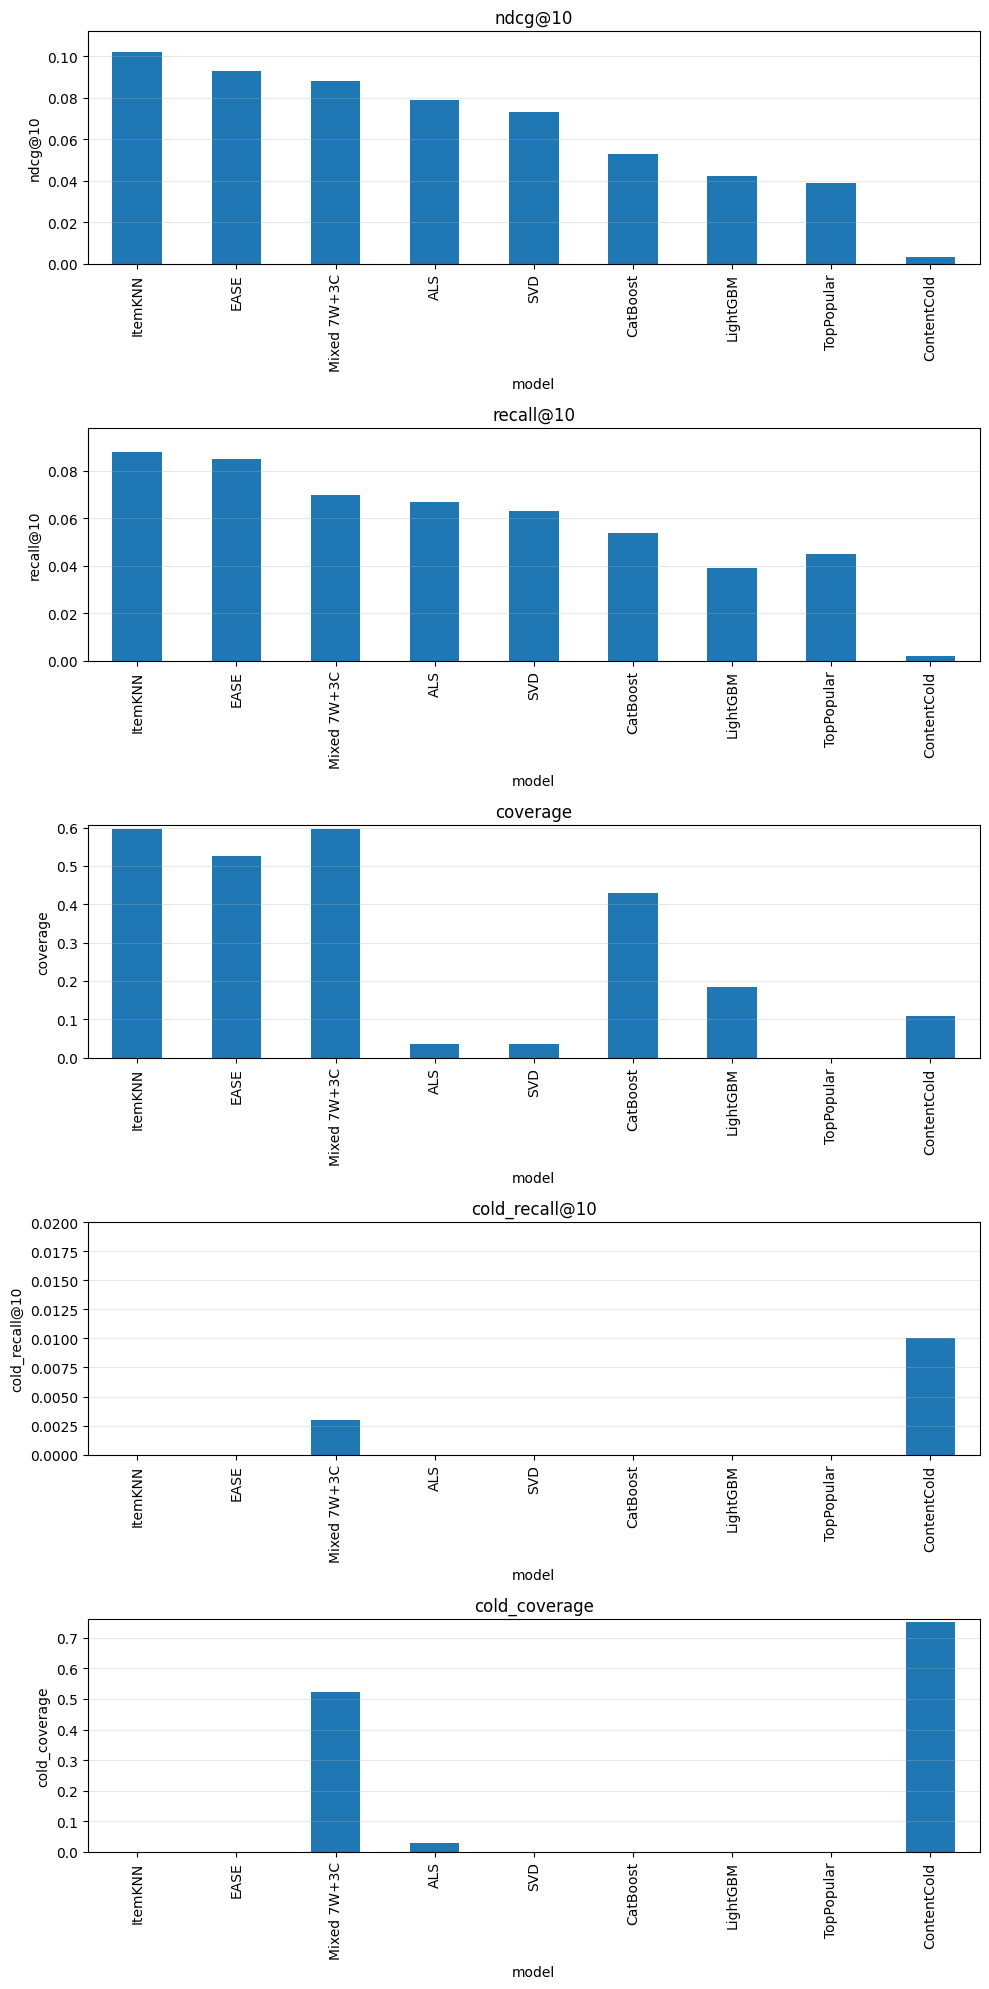

In [ ]:
metrics_to_plot = ["ndcg@10", "recall@10", "coverage", "cold_recall@10", "cold_coverage"]
eps = 0.01

fig, axes = plt.subplots(nrows=len(metrics_to_plot), ncols=1, figsize=(10, 4*len(metrics_to_plot)))
if len(metrics_to_plot) == 1:
    axes = [axes]

for ax, m in zip(axes, metrics_to_plot):
    plot_df = results_df[[m]].copy()
    plot_df.plot(kind="bar", ax=ax, legend=False)
    ymax_data = float(np.nanmax(plot_df[m].values)) if not plot_df.empty else 0.0
    y_max = min(ymax_data + eps, 1.0)
    y_max = max(y_max, eps)
    ax.set_ylim(0, y_max)
    ax.set_title(m)
    ax.set_ylabel(m)
    ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

In [61]:
results_df.to_csv("artifacts/results_df.csv")

- **Лучшие результаты** показывают `ItemKNN` и `EASE`. Оба хорошо ранжируют тёплые айтемы и покрывают длинный хвост каталога. CF-подходы оптимальны по тёплым, но они не видят холодные айтемы, поэтому получаем нулевые cold метрики
- **Cold‑компонента**: чистый `ContentCold` слабоват по overall (0.003/0.002), но даёт высокий охват холодных (cold_coverage=0.751). Микс добавляет cold‑позиции за счёт TF‑IDF‑ветки, поэтому падают ndcg/recall (часть позиций занимают холодные), но появляется требуемая оценка холодных
- **Warm+cold**: `Mixed 7W+3C` даёт ненулевые cold‑метрики (cold_recall@10=0.003; cold_coverage=0.524) при несильной потере качества относительно ItemKNN
  
- **ALS/SVD**: стабильно ниже `ItemKNN/EASE` по метрикам
- **LTR‑модели**: `CatBoost` и `LightGBM` в текущей конфигурации уступают. Они учатся на теплых сигналах и отдают warm, поэтому cold=0

- **TopPopular**: минимальный overall, нулевой coverage/cold, служит просто baseline

# Дальнейшие действия для улучшения качества

### 1. Усилить warm-ветку
- Тонкая настройка:
  - `ItemKNN`: n_neighbors $\in$ {100, 200, 300, 400}; добавить фильтр «уже видел»
  - `EASE`: l2_reg $\in$ {1e3, 2e3, 3e3, 5e3, 1e4}, topM/topk — баланс точность/скорость
  - `ALS`: factors $\in$ {128, 256}, alpha $\in$ {20, 40, 80}, iterations $\in$ {10, 15, 20}
- Скоринговый ансамбль warm-моделей: нормировать скор `ItemKNN/EASE/ALS` и усреднять с весами (подобрать на валидации), потом использовать как фичу в LTR

### 2. Усилить cold-ветку (контент)
- TF‑IDF получше: ngram_range=(1,2), sublinear_tf=True, max_features 20к–50к
- Профиль пользователя: взвешенное среднее (учёт `is_read`, `rating` и времени — экспоненциальное затухание по `date_added`)
- Кандидаты: top‑K по косинусу (K=300–500), затем rerank и взять топ‑10/топ‑N для миксера
- Альтернативные эмбеддинги: S-BERT/MPNet по `title+description` 

### 3. Двухэтапный LTR-переранжировщик
- Кандидаты: объединить warm (EASE/ALS/ItemKNN по top‑200) + cold (ContentCold по top‑300) + немного popular.
- Фичи LTR:
  - `score_ease`, `score_itemknn`, `score_als`, `content_sim`, поп‑сигналы (`log_pop`, `mean_rating`), бинарный `is_warm`, совпадение автор/серия/теги, длины/наличие описания
  - Персональные: размер истории, средний рейтинг пользователя, новизна (время)
- Модель:
  - LightGBM с `objective='lambdarank'` или `rank_xendcg`, группировка по пользователю
  - CatBoostRanker — увеличить долю cold в кандидатах при predict
- Гарантировать квоту cold в топ‑k

### 4. Персонализация квот
- Если история короткая (например, <10 interactions), повышать долю cold, если длинная — уменьшать долю cold

### 5. Качество данных и фильтры
- Склейка переизданий/томов одной книги (по нормализованному названию/series)
- Баланс popular‑bias: немного штрафовать сверхпопулярные 

### 6. Использование новых моделей
- Графовые модели: улучшают warm и переносится на cold при наличии контента
- BERT4Rec — лучшее ранжирование недавних предпочтений, но cold покрывает через контентные признаки/микс
